# **GDG 인공지능 기초 2주차 과제**
이번 주차 과제는 softmax 실습과, 몇가지 문제로 구성되어있습니다!

## **<span style="color:green"> [ 실습 ] </span> Softmax**


**<span style="color:red"> 1. </span>** 우선 실습에 필요한 모듈을 다운 받아줍니다.

In [47]:
!pip3 install torch torchvision
!pip3 install numpy

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np

In [49]:
import random
import matplotlib.pyplot as plt

random.seed(777)
torch.manual_seed(777)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**<span style="color:red"> 2. </span>** 실습에 사용할 데이터 셋을 받아오고 이전에 했던 간단한 처리들을 해줍시다다

Files already downloaded and verified
Files already downloaded and verified
Train X shape: (50000, 32, 32, 3), Train Y shape: (50000,)
Test X shape: (10000, 32, 32, 3), Test Y shape: (10000,)


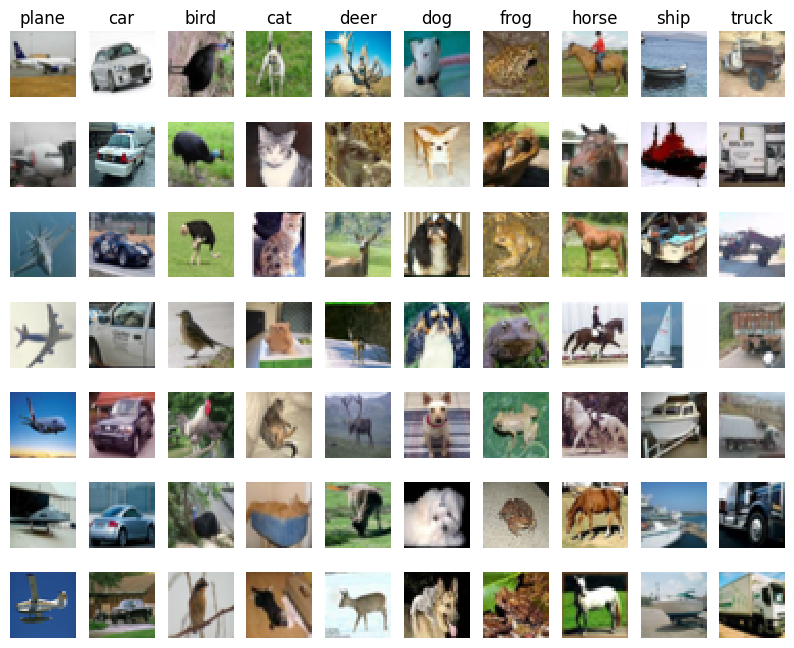

In [50]:
# CIFAR-10 데이터셋 로드
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)

X_train = np.array(train_dataset.data)
y_train = np.array(train_dataset.targets)
X_test = np.array(test_dataset.data)
y_test = np.array(test_dataset.targets) 

# 데이터의 크기 확인
print(f"Train X shape: {X_train.shape}, Train Y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}, Test Y shape: {y_test.shape}")

# 데이터 시각화
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# 데이터 이미지의 차원 변경
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

**<span style="color:red"> 3. </span>**  분류기를 만들고, 학습을 진행합니다. 최적화는 파이토치에 구현되어있는 것으로 했습니다.

In [ ]:
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
# 학습을 용이하게 하기 위해 데이터 정규화
X_train = (X_train - X_train.mean(0)) / X_train.std(0)
X_test = (X_test - X_test.mean(0)) / X_test.std(0)

# 모델 초기화
W = torch.zeros((X_train.shape[1], num_classes), requires_grad=True)
b = torch.zeros((num_classes,), requires_grad=True) 
y_train = torch.Tensor(y_train).long()

# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.01) # 경사하강법, 학습률 = 0.01

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    F = X_train@W + b

    cost = F.cross_entropy(F, y_train)

    # cost로 F(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))
    

AttributeError: 'Tensor' object has no attribute 'cross_entropy'

**<span style="color:red"> 4. </span>** test 데이터를 통해 정확도를 계산합니다다  

In [ ]:
with torch.no_grad():
    logits = X_test@W + b
    score = F.softmax(logits, dim=0)
    pred = torch.argmax(score, dim=1)

correct = (pred == y_test).sum().item()
accuracy = correct / len(y_test)

print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

**<span style="color:red"> 5. </span>** 특정 이미지를 분류한 결과를 볼까요?

In [ ]:
random.seed(123)
num_samples = 5
indices = random.sample(range(X_test.shape[0]), num_samples)
X_check = X_test[indices]
y_check = y_test[indices]

output = X_check @ W + b
probs = F.softmax(output, dim=1)
y_pred = torch.argmax(probs, dim=1)

X_check = np.reshape(X_check, (5, 32, 32, 3))

fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))  # 1행 5열로 이미지 배치
for i, ax in enumerate(axes):
    ax.imshow(X_check[i])  # 이미지 표시
    ax.axis('off')
    ax.set_title(f"Pred: {classes[int(y_pred[i])]}\nTrue: {classes[y_check[i]]}")  # 예측값 & 정답 표시



## **<span style="color:green"> [ 문제 ] </span>**

**<span style="color:red"> 1. </span>** F(x) = Wx + b의 식에서 x의 크기가 (3072 x 100)이고, F(x) 출력의 크기가 (10 x 100)이라면 W와 b의 크기는 어떻게 될까요?

**<span style="color:red"> [정답] </span>** W는 10 * 3072, b는 10

**<span style="color:red"> 2. </span>** Cross-Entropy Loss를 자주 사용하는 경우는 언제일까요?  
① 군집화 문제  
② 회귀 문제  
③ 분류 문제  
④ 시계열 예측 문제    

**<span style="color:red"> [정답] </span>** 3번

**<span style="color:red"> 3. </span>** SVM의 Hinge loss와 Softmax함수의 loss 함수가 가질 수 있는 최댓값과 최솟값의 범위는 어떻게 될까요?

**<span style="color:red"> [정답] </span>** 최솟값은 0, 최댓값은 무한대가 될 수 있다.

**<span style="color:red"> 4. </span>** SVM모델의 F(W, x) = Wx에서 W를 매우 작은 값으로 초기화를 하면 처음 Loss를 계산 했을 때 어떤 값이 나올까요?  
① 0에 가까운 값이 나온다.  
② 1이 나온다.  
③ 총 class의 개수 만큼의 결과가 나온다.  
④ 총 class의 개수 -1 의 결과가 나온다.  

**<span style="color:red"> [정답] </span>** 2번

**<span style="color:red"> 5. </span>** Regularization을 사용하는 이유가 무엇일까요?   
① 데이터의 크기를 확장시키기 위해    
② 과적합을 방지하고 모델을 단순화하기 위해  
③ 모델의 학습 속도를 증가시키기 위해  
④ 모델을 복잡하게 만들어 복잡한 문제를 해결하기 위해    

**<span style="color:red"> [정답] </span>** 2번

## 2주차 과제 끝!
2주차 과제는 여기까지 입니다!

수업 중 이해가 안가거나 어려웠던 부분, 수업에 관한 피드백을 적어주시면 다음 주차 강의에 적극적으로 반영하겠습니다!

이번 실습 코드를 실행하는데 오류가 났는데 코드를 수정하면 안될 것 같아서 정상적으로 실행을 못했어요...
혹시 스터디 때 실습을 먼저 설명해주실 수 있을까요?